In [1]:
import os
import mne
import pandas as pd
import pickle
import numpy as np
from scipy import linalg, stats
from mne import io
from mne.connectivity import spectral_connectivity
import winsound
import warnings
import re
from mne.channels import find_ch_connectivity
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import lil_matrix

In [2]:
#Functions

def makeSound(freq = 6000, # Hz
              duration = 3000): # millisecond
    #import winsound
    winsound.Beep(freq, duration)

def readPythonObject(path):
    #import pickle
    infile = open(path,'rb')
    objectName = pickle.load(infile)
    infile.close()
    return objectName


Loading needed variables for questions.

**The data files can be found here:**

Link to the data files as single ones: 
https://www.dropbox.com/sh/too9bgu6r28jkpu/AAAM603H5fnso30keXL4WRBXa?dl=0

Here is a link to the zip file: 
https://www.dropbox.com/s/lfb3ez430at7h49/EEG%20question%20data.zip?dl=1 (~6.5 GB)

In [3]:
#Downloads the data files to folder it's about 6.5GB
import requests, zipfile, io

r = requests.get("https://www.dropbox.com/s/lfb3ez430at7h49/EEG%20question%20data.zip?dl=1")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()


Read the data 

In [4]:
#Sample data I use to get information like channels names, etc.
combinedBaseline = readPythonObject("combinedBaseline.pkl")
#My calculated connections
conns = readPythonObject("conns.pkl")
#Sensors location settings for the first cap
locations = readPythonObject("locations.pkl")
#Sensors location settings for the two caps
locationSettings = readPythonObject("locationSettings.pkl")
sens_loc = readPythonObject("sens_loc.pkl")
#Additional data
from sklearn.externals import joblib
combinedList = joblib.load("combinedList.pkl")

makeSound()

Calculating data for sparse matrix. 

Because I'm interested only in the connectivity between the caps, the length of the electrodes is 961

In [5]:
#Calculating the number of combinations in the lower matrix trig
nchan = int(len(combinedBaseline.info["ch_names"]))
bin=0
idx = []
electrodes = []
for e1 in range(0, int(nchan / 2)):
    for e2 in range(int(nchan / 2), nchan):
        if e2>e1:
            idx.append(bin)
            electrodes.append((e1, e2))
        bin = bin + 1
print("my idx is:", len(idx))
print("my electrodes is:", len(electrodes))

my idx is: 961
my electrodes is: 961


electrodes reflects the combination of the electrodes in the first cap with the second cap

In [6]:
print("for the first electrode:", electrodes[:31])

for the first electrode: [(0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61)]


The frequency bands I use

In [7]:
freqbands = {'alpha': (8, 14), 'beta': (14, 30), 'gamma': (30, 60)}

Creating 3D ndarray for the connections between the vectors (subject, freq, connections)

In [8]:
frequencies_labels = list(freqbands.keys())
vectconn = np.zeros([len(conns), len(frequencies_labels), len(idx)])
for f_idx, f_lab in enumerate(frequencies_labels):
    for s_idx, s_conn in enumerate(conns):
        vectconn[s_idx, f_idx, :] = s_conn[idx, f_idx]
print("The shape of vectoconn is:", vectconn.shape)

The shape of vectoconn is: (139, 3, 961)


Creating matrix for sparse matrix

Reading ICACorrection_N135_SUBJECT2_PART1_F010_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
198 matching events found
No baseline correction applied
198 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Could not find a connectivity matrix for the data. Computing connectivity based on Delaunay triangulations.
-- number of connected vertices : 31


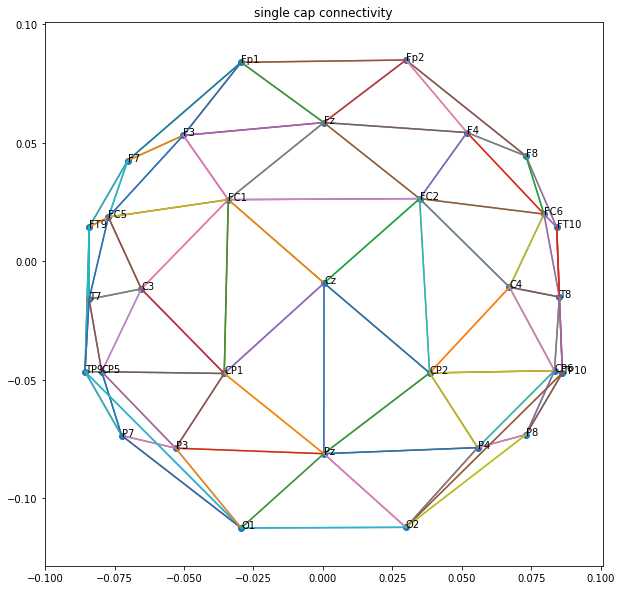

In [11]:
##single cap connectivity
epochs = mne.read_epochs("ICACorrection_N135_SUBJECT2_PART1_F010_epo.fif", preload=True)

##Testing to see that the names of the single/two caps are the same. 
assert [c + "-0" for c in epochs.info["ch_names"]] == [c for c in combinedBaseline.info["ch_names"][:31]], "The channels name in the single and two caps are not the same"

##Calculate connectivity for single cap
x, y = find_ch_connectivity(epochs.info, ch_type="eeg")
##Plot
sensloc = np.array([c['loc'][:3] for c in epochs.info['chs']][:62])
plt.figure(figsize=[10,10])
plt.scatter(sensloc[:, 0], sensloc[:, 1])
plt.title("single cap connectivity")
for i, txt in enumerate(epochs.info["ch_names"]):
        plt.annotate(epochs.info["ch_names"][i], (sensloc[i, 0], sensloc[i, 1]))
for e1 in range(31):
    for e2 in range(31):
        if x[e1,e2]:
            plt.plot((sensloc[e1, 0], sensloc[e2, 0]), (sensloc[e1, 1], sensloc[e2, 1]))

Transforming single cap to two caps and sparse plot

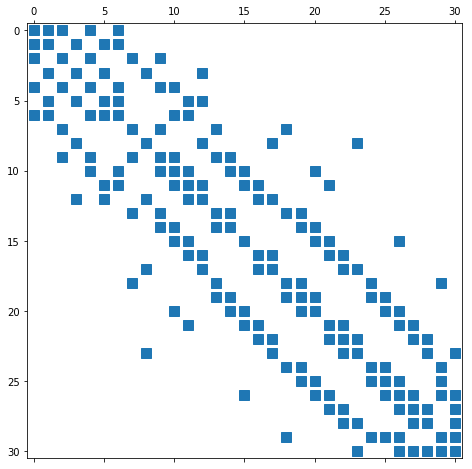

In [12]:
##Transforming single cap to two caps
from scipy.sparse import csr_matrix
A = csr_matrix(x.toarray())

##Plot sprase matrix
plt.figure(figsize=[10,8])
plt.spy(A)
plt.show()


Plot two caps connectivity

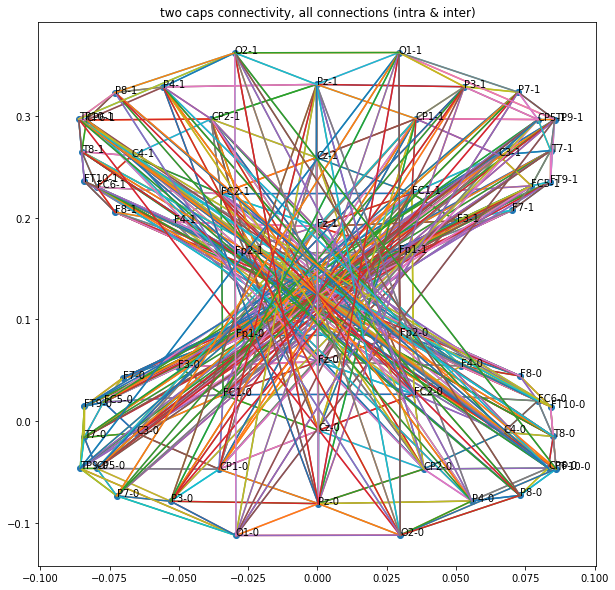

In [13]:
def capTest(x):
    if x >= 31:
        out = x - 31
    else:
        out = x 
    return(out)
    
sensloc = np.array([c['loc'][:3] for c in combinedBaseline.info['chs']][:62])
plt.figure(figsize=[10,10])
plt.scatter(sensloc[:, 0], sensloc[:, 1])
plt.title("two caps connectivity, all connections (intra & inter)")
for i, txt in enumerate(combinedBaseline.info["ch_names"]):
        plt.annotate(combinedBaseline.info["ch_names"][i], (sensloc[i, 0], sensloc[i, 1]))
for e1 in range(62):
    for e2 in range(62):
        k1, k2 = list(map(capTest, [e1, e2]))
        if A[k1, k2]:
            plt.plot((sensloc[e1, 0], sensloc[e2, 0]), (sensloc[e1, 1], sensloc[e2, 1]))

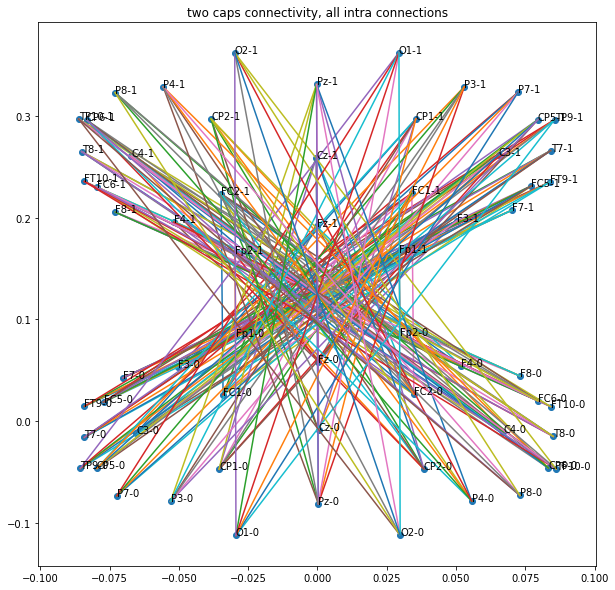

In [22]:
sensloc = np.array([c['loc'][:3] for c in combinedBaseline.info['chs']][:62])
plt.figure(figsize=[10,10])
plt.scatter(sensloc[:, 0], sensloc[:, 1])
plt.title("two caps connectivity, all intra connections")
for i, txt in enumerate(combinedBaseline.info["ch_names"]):
        plt.annotate(combinedBaseline.info["ch_names"][i], (sensloc[i, 0], sensloc[i, 1]))
for e1 in range(62):
    for e2 in range(62):
        k1, k2 = list(map(capTest, [e1, e2]))
        if A[k1, k2] and e1 <= 30 and e2 >= 31:
            plt.plot((sensloc[e1, 0], sensloc[e2, 0]), (sensloc[e1, 1], sensloc[e2, 1]))

Calculate metaconn. 

**Note**: because A was defined by the connections of one cap, I need to match the positions of electrodes in cap 2 to the positions in cap 1. I'm doing that by subtracting 31 from the electrodes in cap 2. 

In [15]:
metaconn = np.zeros((vectconn.shape[-1], vectconn.shape[-1]))
for ne1, (e11,e12) in tqdm(enumerate(electrodes)):
    for ne2, (e21,e22) in enumerate(electrodes):
        #Testing to see if the channel is from cap 1 or 2. 
        #if from cap2 I subtract 31 to know the location. 
        k11, k12, k21, k22 = list(map(capTest, [e11, e12, e21, e22]))
        #Calculate metaconn
        metaconn[ne1, ne2] = (A[k11, k21])
        
print(vectconn.shape[-1])
makeSound()

961it [00:31, 30.35it/s]


961


Ploting metaconn. 

Now it make sense as it looks one cap. 

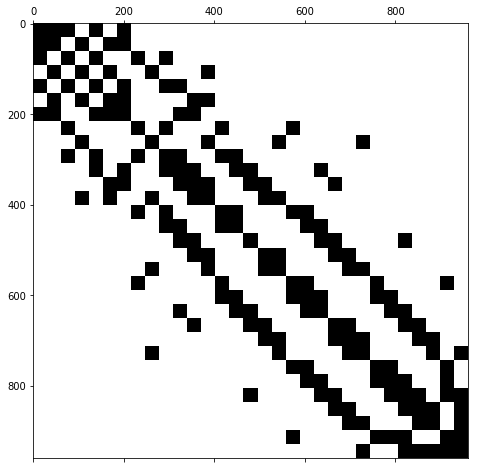

In [17]:
plt.figure(figsize=[10,8])
plt.spy(metaconn)
plt.show()

Adding group value to vectconn

In [18]:
grps = np.zeros(vectconn.shape[0])
count = -1
for s_idx, c in tqdm(enumerate(combinedList)):
    for i, cSub in enumerate(c[1]):
        count +=1
#        print(cSub[i].info["subject_info"]["ID"])
        if cSub[i].info["subject_info"]["ID"][1] == "1" and cSub[i].info["subject_info"]["active"] == "m":
            grps[count] = 1
        elif cSub[i].info["subject_info"]["ID"][1] == "1" and cSub[i].info["subject_info"]["active"] == "f":
            grps[count] = 2
        elif cSub[i].info["subject_info"]["ID"][1] == "2" and cSub[i].info["subject_info"]["active"] == "m":
            grps[count] = 3
        elif cSub[i].info["subject_info"]["ID"][1] == "2" and cSub[i].info["subject_info"]["active"] == "f":
            grps[count] = 4
        elif cSub[i].info["subject_info"]["ID"][1] == "3" and cSub[i].info["subject_info"]["active"] == "m":
            grps[count] = 5
        elif cSub[i].info["subject_info"]["ID"][1] == "3" and cSub[i].info["subject_info"]["active"] == "f":
            grps[count] = 6
            
print("Number of male couples:", len([i for i in grps.tolist() if i == 1]))
print("Number of female couples:", len([i for i in grps.tolist() if i == 2]))
print("Number of male best friends:", len([i for i in grps.tolist() if i ==3]))
print("Number of female best friends:", len([i for i in grps.tolist() if i ==4]))
print("Number of male strangers:", len([i for i in grps.tolist() if i ==5]))
print("Number of female strangers:", len([i for i in grps.tolist() if i ==6]))

70it [00:01, 46.69it/s]


Number of male couples: 26
Number of female couples: 27
Number of male best friends: 14
Number of female best friends: 14
Number of male strangers: 29
Number of female strangers: 29


**Calculating permutation *with clusters***

**BUG? - I'm not sure the clusters are actually calculated well. I get really huge clusters**

In [19]:
fobsList = []
clustersList = []
cluster_pvList = []
H0List = []
pvalue = 0.05
for f_idx, f_lab in enumerate(frequencies_labels):
    print(f_idx, f_lab)
    data1 = vectconn[np.argwhere(grps==1), f_idx, :]
    data2 = vectconn[np.argwhere(grps==2), f_idx, :]
    data3 = vectconn[np.argwhere(grps==3), f_idx, :]
    data4 = vectconn[np.argwhere(grps==4), f_idx, :]
    data5 = vectconn[np.argwhere(grps==5), f_idx, :]
    data6 = vectconn[np.argwhere(grps==6), f_idx, :]
    romantic = np.concatenate([data1, data2], axis = 0)
    goodFriends = np.concatenate([data3, data4], axis = 0)
    strangers = np.concatenate([data5, data6], axis = 0)
    Fobs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test(X=[romantic, strangers, goodFriends],
                                                                        tail=0,
                                                                        n_permutations = 1000,
                                                                        seed = 42, 
                                                                        step_down_p = pvalue,
                                                                        connectivity = lil_matrix(metaconn), 
                                                                        check_disjoint = False)
    fobsList.append(Fobs)
    clustersList.append(clusters)
    cluster_pvList.append(cluster_pv)
    H0List.append(H0)

0 alpha


<ipython-input-19-581e87b07188>:23: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  check_disjoint = False)


Using a threshold of 3.062700
stat_fun(H1): min=0.001421 max=15.329529
Running initial clustering
Found 1 clusters
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
1 beta


<ipython-input-19-581e87b07188>:23: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  check_disjoint = False)


Using a threshold of 3.062700
stat_fun(H1): min=0.007325 max=13.907695
Running initial clustering
Found 1 clusters
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
2 gamma


<ipython-input-19-581e87b07188>:23: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  check_disjoint = False)


Using a threshold of 3.062700
stat_fun(H1): min=0.005309 max=17.862041
Running initial clustering
Found 1 clusters
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.


**How many p-values I have for each band**

In [20]:
for c, p in enumerate(cluster_pvList):
    print("for freq", frequencies_labels[c], "I have" , len([pv for pv in p if pv < pvalue]), "pvs")

for freq alpha I have 1 pvs
for freq beta I have 1 pvs
for freq gamma I have 1 pvs


Graphing the significant connections

**BUG? - for some odd reason it gives me all the connections**

As if one cluster includes all the channels

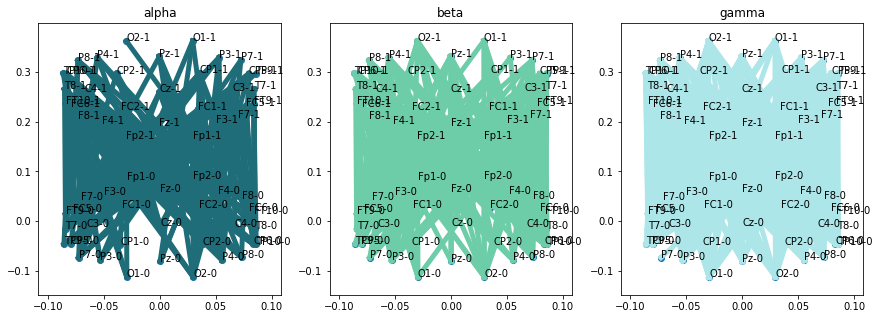

In [21]:
l = []
sensloc = np.array([c['loc'][:3] for c in combinedBaseline.info['chs']][:62])
plt.figure(figsize=[20,5])
for f_idx, f_lab in enumerate(frequencies_labels):
    cluster_pv = cluster_pvList[f_idx]
    clusters = clustersList[f_idx]
    assert len(cluster_pv) == len(clusters)
    plt.subplot(1,4,f_idx+1)
    plt.scatter(sensloc[:, 0], sensloc[:, 1])
    #Add channels' name
    for i, txt in enumerate(combinedBaseline.info["ch_names"]):
        plt.annotate(combinedBaseline.info["ch_names"][i], (sensloc[i, 0], sensloc[i, 1]))
    #Plot significant connections
    if len(cluster_pv) > 0:
        for cl_idx, cluster in enumerate(clusters):
            if cluster_pv[cl_idx] < pvalue:
#                print(cl_idx, cluster_pv[cl_idx])
                color = np.random.rand(3)
                for ne, (e1,e2) in enumerate(electrodes):
                    if cluster[0][ne]:
                        l.append([f_lab, ne, (e1,e2)])
                        plt.plot((sensloc[e1, 0], sensloc[e2, 0]), (sensloc[e1, 1],
                                 sensloc[e2, 1]), linewidth=5, color=color)
        plt.title(f_lab)